In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import h5py
import os
import sys
import random
sys.path.insert(0, '/s/ls4/users/sbobkov/EuXFEL/xfel2013/offline')
import combine_modules as combm
import scipy.io as sio
from scipy.signal import argrelextrema
import geom
import analysis_helper as ahelp
from scipy.ndimage.filters import gaussian_filter

/s/ls4/users/sbobkov/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import logging
logging.basicConfig(filename='extract_images_log.log',level=logging.DEBUG)

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

def fill_2d_subplot(axes, data_2d, vmin=1, vmax=10, logscale=False):
    if logscale:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    cmap = plt.cm.jet
    cmap.set_under(color='white')
        
    im = axes.imshow(data_2d, cmap=cmap, norm=norm, interpolation='none')    
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

base_exp_folder = '/s/ls4/users/teslyuk/p002013/'

def get_run_numbers():
    runs_folders = os.listdir(base_exp_folder)
    return [int(fn[1:]) for fn in runs_folders]

def get_series_numbers(run_num):
    run_folder = '%s/r%04d'%(base_exp_folder, run_num)
    run_files = os.listdir(run_folder)
    series = set([int(fname.split('.')[0].split('-')[-1][1:]) for fname in run_files])
    return series

def get_agipd_panel_numbers(run_num):
    run_folder = '%s/r%04d'%(base_exp_folder, run_num)
    run_files = os.listdir(run_folder)
    agipd_panels = set([int(fname.split('.')[0].split('-')[2][5:]) for fname in run_files  if 'AGIPD' in fname])
    return agipd_panels

def open_h5_det_file(run_num, series, panel):
    fname = '%s/r%04d/RAW-R%04d-AGIPD%02d-S%05d.h5'%(base_exp_folder, run_num, run_num, panel, series)
    if os.path.isfile(fname):
        return h5py.File(fname, "r")
    else:
        logging.warning('No file for current parameters\n')
        return -1

def list_run_files(run_num):
    run_folder = '%s/r%04d'%(base_exp_folder, run_num)
    return os.listdir(run_folder)

# runs = sorted(get_run_numbers())
# series = sorted(get_series_numbers(runs[-1]))
# agipd_panels = sorted(get_agipd_panel_numbers(runs[-1]))
# h5file = open_h5_det_file(runs[-1], series[-1], agipd_panels[-1])

# for k in h5file.keys():
#     print(k)



In [8]:
def get_agipd_image(run_num, series, panel):
    fname = '%s/r%04d/RAW-R%04d-AGIPD%02d-S%05d.h5'%(base_exp_folder, run_num, run_num, panel, series)
    print(fname)
    if os.path.isfile(fname):
        h5file = h5py.File(fname, "r")
    else:
        logging.warning('No file for current parameters\n')
        return -1
    
    dset_name = '/INSTRUMENT/SPB_DET_AGIPD1M-1/DET/%dCH0:xtdf/image/data' % panel
    
    if dset_name not in h5file:
        logging.warning('No image data in file\n')
        return -1
    
    return h5file[dset_name]
        
runs = sorted(get_run_numbers())
series = sorted(get_series_numbers(runs[-1]))
agipd_panels = sorted(get_agipd_panel_numbers(runs[-1]))

image_data = get_agipd_image(200, series[-1], agipd_panels[-1])
print image_data

print('Found data for %d images' % image_number)

/s/ls4/users/teslyuk/p002013//r0200/RAW-R0200-AGIPD15-S00004.h5
<HDF5 dataset "data": shape (16000, 2, 512, 128), type "<u2">
Found data for 16000 images


In [13]:
#Load mask
geom_file = '/s/ls4/users/sbobkov/EuXFEL/xfel2013/geometry/agipd_taw9_oy2_1050addu_hmg5.geom'
geom_coord_x, geom_coord_y = geom.pixel_maps_from_geometry_file(geom_file)
empty_frame = np.ones((16,512,128))
empty_image = geom.apply_geom_ij_yx((geom_coord_x, geom_coord_y), empty_frame).transpose()
mask = (empty_image-1)*10000

In [34]:
#Load random image

run_num = sorted(get_run_numbers())[-1]

c = combm.AGIPD_Combiner(247, geom_fname=geom_file)
image = c.get_frame(21346, calibrate=False, assemble=False).transpose()

29970 good frames in run


65536


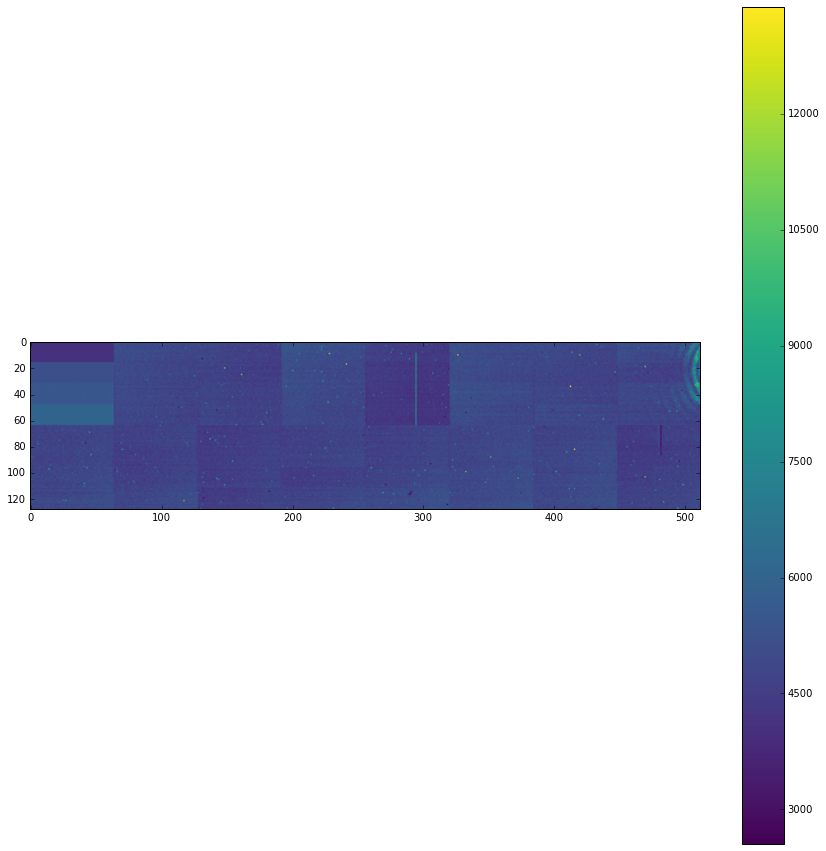

In [36]:
#Plot image
selected_region = image[:,:,15]

cmap = plt.cm.viridis
cmap.set_under(color='white')
fig = plt.figure(figsize=(15, 15))
plt.imshow(selected_region, cmap=cmap) 
plt.colorbar()

print(np.sum(selected_region>1))

In [20]:
# random_image = c.get_frame(123, calibrate=True, assemble=False).transpose()
hist,bins = np.histogram(image[:,:,15],bins=100,  range=(0,200))

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111)
im_1 = ax1.plot(bins[:-1],hist)
plt.xlabel('Intensity')
plt.ylabel('Histogram')

In [ ]:
#Compute humber of hits and hitrate
# hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/ayyerkar/xfel2013/offline/data/'
hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/sbobkov/xfel2013/offline/data/'
shift2_run_numbers = range(214,267+1)

good_images = [[]]*len(shift2_run_numbers)
number_of_hits = np.zeros(len(shift2_run_numbers))
hitrate = np.zeros(len(shift2_run_numbers))

for i,run_num in enumerate(shift2_run_numbers):
    try:
        with h5py.File(hits_folder+'hits_r%.4d.h5'%run_num, 'r') as h5file:
            litpix = h5file['hitFinding/litPixels'][:]
            trainids = h5file['hitFinding/trainId']
            cellids = h5file['hitFinding/cellId']
            litpix_threshold = h5file['hitFinding/litPixelThreshold']
            good_cells = h5file['hitFinding/goodCells']

            thresh = np.array([litpix[i::len(good_cells)].mean() + litpix[i::len(good_cells)].std()*2 for i in range(len(good_cells))])
            indices = np.where((litpix.reshape(-1, len(good_cells)) > thresh).flatten())[0]
            number_of_hits[i] = len(indices)
            print(run_num,len(indices),len(litpix))
#             print(thresh)
            hitrate[i] = (1.0*len(indices))/len(litpix)
            good_images[i] = indices
    except OSError:
        print('Missing',run_num)
        continue


In [ ]:
np.sum(number_of_hits)

In [ ]:
print(number_of_hits)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111)
im_1 = ax1.plot(shift2_run_numbers,hitrate*100)
plt.xlabel('Run number')
plt.ylabel('Hit rate, %')

In [ ]:
#Compute lit histogram for each cell
# hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/ayyerkar/xfel2013/offline/data/'
hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/sbobkov/xfel2013/offline/data/'
run_number = 340
nbins = 100
hist_range = (0,500)

with h5py.File(hits_folder+'hits_r%.4d.h5'%run_number, 'r') as h5file:
    litpix = h5file['hitFinding/litPixels'][:]
    good_cells = h5file['hitFinding/goodCells'][:]
    lit_histogram = np.zeros((len(good_cells),nbins))
    bins_values = np.zeros((len(good_cells),nbins+1))
    mean_values = np.zeros(len(good_cells))
    std_values = np.zeros(len(good_cells))
    for i in range(len(good_cells)):
        lit_histogram[i], bins_values[i] = np.histogram(litpix[i::len(good_cells)], bins=nbins, range=hist_range)
        mean_values[i] = litpix[i::len(good_cells)].mean()
        std_values[i] = litpix[i::len(good_cells)].std()

In [ ]:
#Litpixels histogram
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
for i in range(len(good_cells)):
    im_1 = ax1.plot(bins_values[i,:-1],lit_histogram[i])
    plt.axvline(x=mean_values[i], color=im_1[0].get_color(), linestyle='-')
    plt.axvline(x=mean_values[i]+2*std_values[i], color=im_1[0].get_color(), linestyle='--')
    
ax1.set_xlim([0,500])
print(litpix.mean(),litpix.std())

In [ ]:
#Litpixels histogram in 3d
fig = plt.figure(figsize=(11, 11))
ax1 = fig.add_subplot(111, projection='3d')
XX, YY = np.meshgrid(bins_values[0,:-1],good_cells)

im = ax1.plot_wireframe(XX, YY, lit_histogram)
plt.ylabel('Cell number')
plt.xlabel('Number of litpixels')
fig.savefig('run%d_litpix_histogram.png'%run_number,dpi=300, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(11, 11))
ax1 = fig.add_subplot(111)

im1 = ax1.plot(good_cells, mean_values,  label='Mean values')
im2 = ax1.plot(good_cells, std_values+mean_values,  label='Mean+Std values')
plt.ylabel('Cell number')
plt.legend()

In [537]:
#Load all_mimi_hits data
# hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/ayyerkar/xfel2013/offline/data/'
hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/sbobkov/xfel2013/offline/data/'

with h5py.File(hits_folder+'all_mimi_hits.h5', 'r') as h5file:
    adu = h5file['images'][:]
    adu_bgfill = h5file['processing/images_bgfill'][:]
    photons = h5file['photons/images'][:]
#     images = h5file['images'][:]
#     images[images<0] = 0
    photons[photons<0] = 0
    intensity = np.sum(images,axis=(1,2))
    
    runs = h5file['run_number'][:]
    indices = h5file['indices'][:]
    if 'analysis' in h5file:
        radial_data_adu = h5file['analysis/radial_images'][:]
        fvs_data_adu = h5file['analysis/fvs_images'][:]
        radial_data_adu_bgfill = h5file['analysis/radial_images_bgfill'][:]
        fvs_data_adu_bgfill = h5file['analysis/fvs_images_bgfill'][:]
        radial_data_photons = h5file['analysis/radial_photons'][:]
        fvs_data_photons = h5file['analysis/fvs_photons'][:]
    else:
        radial_data = None
        fvs_data = None

In [548]:
with h5py.File(hits_folder+'all_mimi_hits.h5', 'a') as h5file:
    single_selection_name = 'single_selection/'
    if single_selection_name in h5file:
        del h5file[single_selection_name]
        
    infile_index_dset = h5file.create_dataset(single_selection_name+'infile_index',\
                                              shape=selected_idx.shape, dtype='u4')
    
    run_number_dset = h5file.create_dataset(single_selection_name+'run_number',\
                                              shape=selected_idx.shape, dtype='u4')
    
    indices_dset = h5file.create_dataset(single_selection_name+'indices',\
                                              shape=selected_idx.shape, dtype='u4')
    
    infile_index_dset[:] = selected_idx.astype('u4')
    run_number_dset[:] = runs[selected_idx].astype('u4')
    indices_dset[:] = indices[selected_idx].astype('u4')

In [5]:
#Sorted intensity
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111)
ax.plot(sorted(intensity[:]))
ax.set_yscale('log')
# ax.set_ylim(ymin=1,ymax=100000000)

In [86]:
selected_filter = (intensity>1000)
selected_idx = np.nonzero(selected_filter)[0]
print(selected_idx.shape)

(65083,)


In [95]:
#Intensity histogram
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111)
im = ax.hist(intensity,bins=100, range=(0,15000))
im = ax.hist(intensity[selected_idx],bins=100, range=(0,15000))
ax.set_yscale('log')

In [94]:
#Intensity histogram
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111)
im = ax.hist(litpix_num,bins=100)
im = ax.hist(litpix_num[selected_idx],bins=100)
ax.set_yscale('log')

In [428]:
run_318_single = [62, 123, 133, 151, 157, 231, 307, 319, 363, 605, 628, 826, 896, 1032, 1394]

single_hits = [32107, 27604, 2107,8499,50349,10664,55563,86784,52830,31574,70468,63726,6522, \
              28100, 69750,29018,61540, 38244,86174,26544,17911, 49127, 11850,62891, 23744,49127, 82178,\
              973,48245, 45050, 3300, 28684,64898,26544,67495,148,70705,61256,51626, 15855,59634,32107, \
              1032,605,73962,85127,40997,59747,49976,51644,49976,76698]+run_318_single

multihits = [9890, 79566, 75570, 46088,20401,20401, 35607,12396,2474,54239,4443,24028, 33893,26250,59678,\
            21826, 10356,58596, 13790, 44973, 43581,84685, 50738,54236,64040,18681, 55804,10682, 58499,\
            17064, 19995, 45227, 38936,5258, 36599, 38058, 69428,25968,7645, 46232,39729, 52752,60702,77164, 76714,\
            9636, 8414, 80500,29414, 11405, 46823, 47339, 50756,69428, 77164, 56115, 63664, 60489,\
            17911, 28358, 65498, 22144, 85785,71207, 80500, 14508, 12189,22318, 52179, 4359, 52137, 76714, 25409,\
            7199, 56882, 13718, 39726, 57302, 85785,81958,50756,25158, 63258, 82808, 5258, 7697,31696, 74687, 61878,
            27462,63566, 61878, 18649, 49480,46823, 63396, 10221,69428, 74329, 10716, 55336,72191,54318,36187]

In [417]:
first_max = np.zeros(images.shape[0],dtype=int)
litpix_num = np.zeros(images.shape[0],dtype=int)
fringe_size = np.zeros(images.shape[0],dtype=np.float32)
fringe_size_std = np.zeros(images.shape[0],dtype=np.float32)
min_max_ratio = np.zeros(images.shape[0],dtype=np.float32)
for i in range(images.shape[0]):
    if i%10000 == 0:
        print(i)
    max_pos = argrelextrema(radial_data[i,:40], np.greater)[0]
    min_pos = argrelextrema(radial_data[i,:40], np.less)[0]
    if(len(max_pos)>=2) and (len(min_pos)>=1) and (radial_data[i, max_pos[0]] > radial_data[i, min_pos[0]]):
        max_diff = np.array([max_pos[i]-max_pos[i-1] for i in range(1,len(max_pos))], dtype = np.float32)
        first_max[i] = max_pos[0]
        fringe_size[i] = np.mean(max_diff)
        fringe_size_std[i] = np.std(max_diff)
        litpix_num[i] = np.sum(images[i]>0)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [429]:
learn_idx = np.hstack((single_hits,multihits))
learn_type = np.hstack((np.ones_like(single_hits),np.zeros_like(multihits)))

print(learn_idx,learn_type)


[32107 27604  2107  8499 50349 10664 55563 86784 52830 31574 70468 63726
  6522 28100 69750 29018 61540 38244 86174 26544 17911 49127 11850 62891
 23744 49127 82178   973 48245 45050  3300 28684 64898 26544 67495   148
 70705 61256 51626 15855 59634 32107  1032   605 73962 85127 40997 59747
 49976 51644 49976 76698    62   123   133   151   157   231   307   319
   363   605   628   826   896  1032  1394  9890 79566 75570 46088 20401
 20401 35607 12396  2474 54239  4443 24028 33893 26250 59678 21826 10356
 58596 13790 44973 43581 84685 50738 54236 64040 18681 55804 10682 58499
 17064 19995 45227 38936  5258 36599 38058 69428 25968  7645 46232 39729
 52752 60702 77164 76714  9636  8414 80500 29414 11405 46823 47339 50756
 69428 77164 56115 63664 60489 17911 28358 65498 22144 85785 71207 80500
 14508 12189 22318 52179  4359 52137 76714 25409  7199 56882 13718 39726
 57302 85785 81958 50756 25158 63258 82808  5258  7697 31696 74687 61878
 27462 63566 61878 18649 49480 46823 63396 10221 69

In [430]:
from sklearn import svm

used_data = fvs_data_adu

svm_mashine = svm.SVC(kernel='linear', probability = True, C=1)
svm_mashine.fit(used_data[learn_idx], learn_type)
predicted_types = list(svm_mashine.predict(used_data))
quality_data = svm_mashine.decision_function(used_data)
proba = svm_mashine.predict_proba(used_data)

In [431]:
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111)
im = ax.scatter(quality_data,range(len(predicted_types)),c='k')
im = ax.scatter(quality_data[multihits],multihits,c='b')
im = ax.scatter(quality_data[single_hits],single_hits,c='r')
print(proba.shape)

(87929, 2)


6329 87929


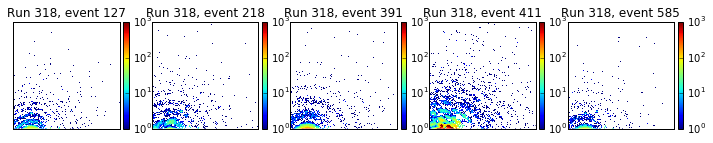

In [432]:
svm_result_filter = quality_data>1
svm_selected = np.where(svm_result_filter)[0]
print(len(svm_selected),len(quality_data>10))

fig = plt.figure(figsize=(12, 12))
cmap = plt.cm.jet
cmap.set_under(color='white')
for i in range(5):
    ax = fig.add_subplot(1,5,i+1)
    fill_2d_subplot(ax, images[svm_selected[i]], vmin=1, vmax=1000, logscale=True)
    ax.set_title('Run %d, event %d'% (runs[svm_selected[i]], indices[svm_selected[i]]))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

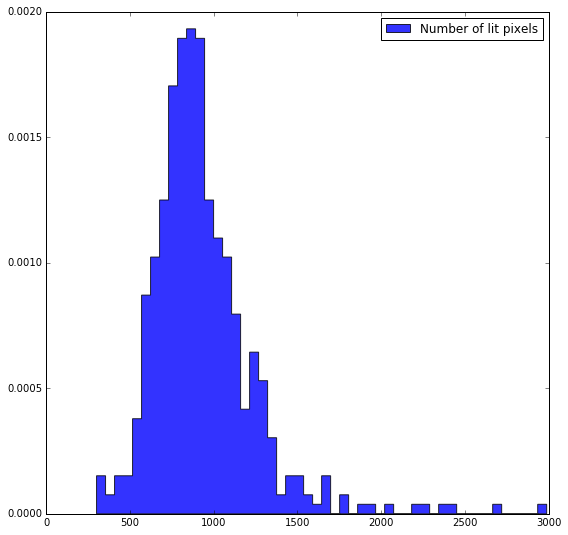

In [464]:
#Params histogram
used_filter = selected_idx
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
# ax.hist(first_max[used_filter], histtype="stepfilled", bins=20, alpha=0.8, normed=True, label='First max')
# ax.hist(fringe_size[used_filter], histtype="stepfilled", bins=40, alpha=0.8, normed=True, label='Fringe size')
# ax.hist(fringe_size_std[used_filter], histtype="stepfilled", bins=20, alpha=0.8, normed=True, \
#         label='Fringe size std')
ax.hist(litpix_num[used_filter], histtype="stepfilled", bins=50, alpha=0.8, normed=True, \
        label='Number of lit pixels')

pltleg = plt.legend()
# fig.savefig('Size dist',dpi=150,bbox_layout='tight')

In [541]:
selected_filter = (fringe_size>=7.1)*(fringe_size<=7.9)*(fringe_size_std<=2)*svm_result_filter
# selected_filter = (fringe_size_std<=4)*(first_max<=18)*(fringe_size<=8)*(fringe_size>=7.5)*svm_result_filter
# selected_filter = svm_result_filter
# selected_filter = (corr_value>0.0008)*(min_max_ratio >1.5)*(fringe_size>6)*(fringe_size<8)
selected_idx = np.nonzero(selected_filter)[0]
print(selected_idx.shape)
# print(corr_value[good_idx])


(491,)


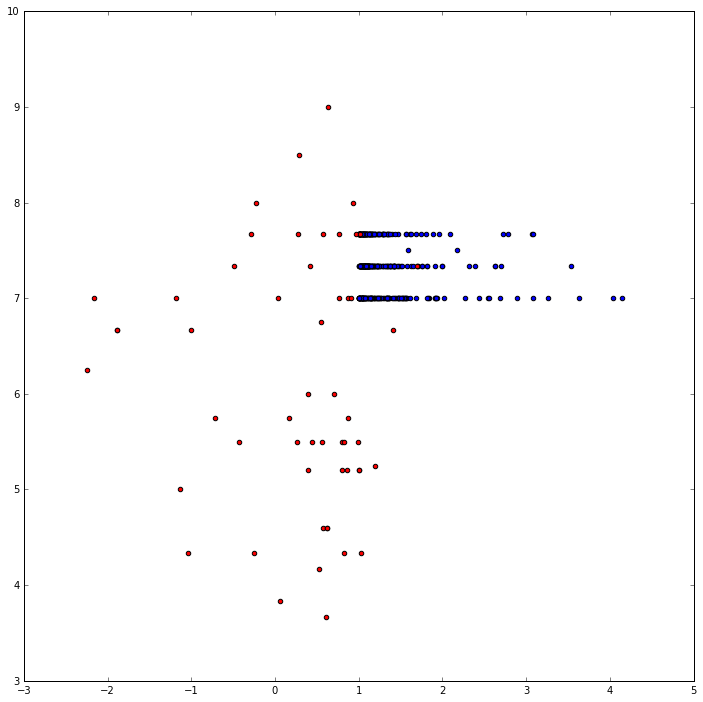

In [420]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(quality_data[selected_idx],fringe_size[selected_idx])
ax.scatter(quality_data[single_hits],fringe_size[single_hits],c='r')

In [74]:
small_particles = np.nonzero(fringe_size>=15)[0]
print(small_particles)

[   93  1407  3495  3861  6230  9299 10031 12143 12818 16896 18362 18777
 19195 19683 27452 27968 31992 32088 37452 37819 38955 43154 43445 45196
 45880 49896 54899 56666 60203 65890 75324 87043]


[47403, 44274, 78178, 34614, 43695]
[21631, 40584, 10987, 63482, 41502]
[77473, 84261, 70930, 45761, 21631]


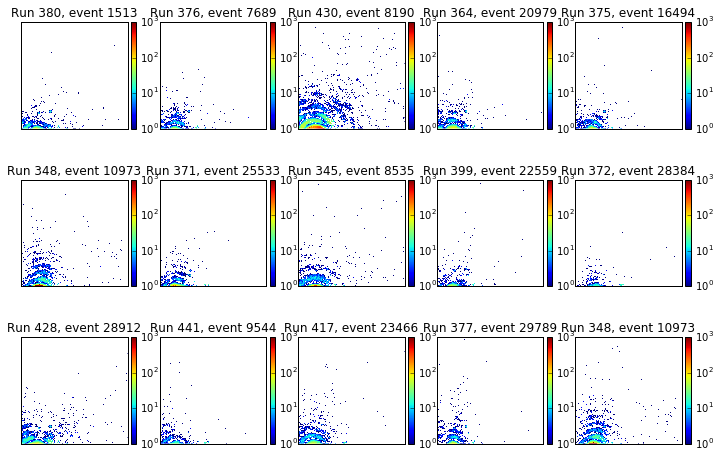

In [534]:
#Show random selected images
fig = plt.figure(figsize=(12, 8))
cmap = plt.cm.jet
cmap.set_under(color='white')

random_in_selected_idx = [random.choice(selected_idx) for i in range(25)]
# random_in_selected_idx = [random.choice(small_particles) for i in range(25)]
# random_in_selected_idx = [random.choice(single_max_idx) for i in range(25)]

for i in range(3):
    print(random_in_selected_idx[i*5:(i+1)*5])
    
for i in range(15):
    ax = fig.add_subplot(3,5,i+1)
    fill_2d_subplot(ax, photons[random_in_selected_idx[i]], vmin=1, vmax=1000, logscale=True)
    ax.set_title('Run %d, event %d'% (runs[random_in_selected_idx[i]], indices[random_in_selected_idx[i]]))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()
# fig.savefig('goodhit_shift4_362_log.png',dpi=300, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(11, 30))
cmap = plt.cm.jet
cmap.set_under(color='white')

random_in_selected_idx = [random.choice(selected_idx) for i in range(25)]
# random_in_selected_idx = [random.choice(single_max_idx) for i in range(25)]
    
for i in range(10):
    ax = fig.add_subplot(10,2,2*i+1)
    fill_2d_subplot(ax, adu_bgfill[random_in_selected_idx[i]], vmin=1, vmax=100, logscale=True)
    ax.set_title('Run %d, event %d'% (runs[random_in_selected_idx[i]], indices[random_in_selected_idx[i]]))
    
    ax = fig.add_subplot(10,2,2*i+2)
    fill_2d_subplot(ax, adu[random_in_selected_idx[i]], vmin=1, vmax=100, logscale=True)
    ax.set_title('Run %d, event %d'% (runs[random_in_selected_idx[i]], indices[random_in_selected_idx[i]]))

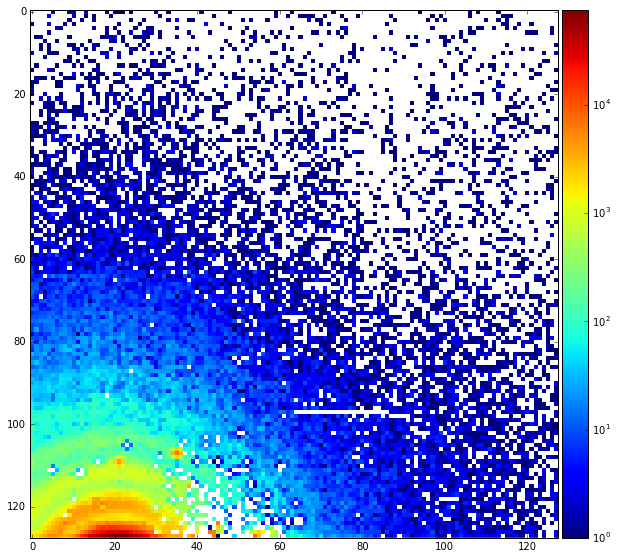

In [539]:
sum_image = np.sum(photons[selected_idx],axis=0)
# print(len(selected_idx))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(sum_image,norm=colors.LogNorm(vmin=1,vmax=np.amax(sum_image)),interpolation='none')
fill_2d_subplot(ax,sum_image,vmin=1,vmax=np.amax(sum_image),logscale=True)
# sio.savemat('single_mimi_491.mat',{'sum_image':sum_image, \
#                                     'single_images':images[selected_idx], \
#                                     'single_index':selected_idx, \
#                                     'run_number':runs[selected_idx], \
#                                     'event':indices[selected_idx]})

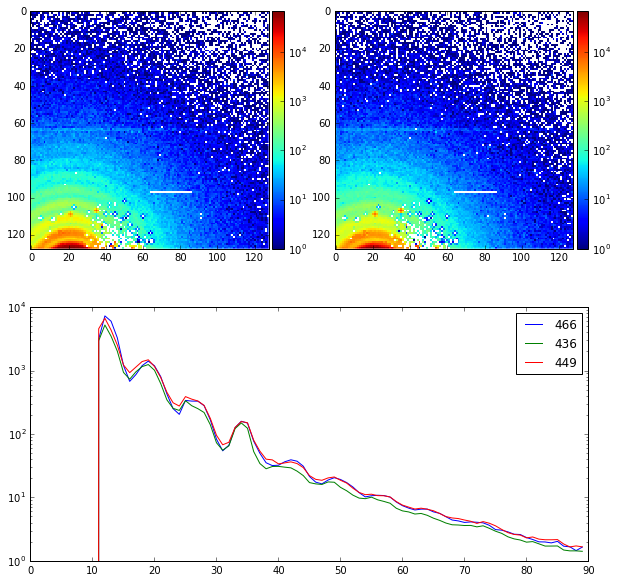

In [460]:
image_1 = sio.loadmat('single_mimi_466.mat')['sum_image']
indices_1 = sio.loadmat('single_mimi_466.mat')['single_index'][0]
image_2 = sio.loadmat('single_mimi_436.mat')['sum_image']
indices_2 = sio.loadmat('single_mimi_436.mat')['single_index'][0]

xi, yi, nr, nt = ahelp.getXiYiForPolarCoords(sum_image.shape,0,90)
radial_1 = ahelp.reprojectImageByCoords(image_1, xi, yi, nr, nt, (138,21)).mean(axis=1)
radial_2 = ahelp.reprojectImageByCoords(image_2, xi, yi, nr, nt, (138,21)).mean(axis=1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221)
fill_2d_subplot(ax,image_1,vmin=1,vmax=np.amax(image_1),logscale=True)
ax = fig.add_subplot(222)
fill_2d_subplot(ax,image_2,vmin=1,vmax=np.amax(image_2),logscale=True)
ax = fig.add_subplot(212)
ax.plot(radial_1,label='466')
ax.plot(radial_2,label='436')
ax.plot(radial,label='449')
ax.set_yscale('log')
ax.legend()

In [277]:
print(indices_1.shape)
print(indices_2.shape)
ind_intersect = np.intersect1d(indices_1, indices_2, assume_unique=True)
print(len(ind_intersect))

(466,)
(436,)
56


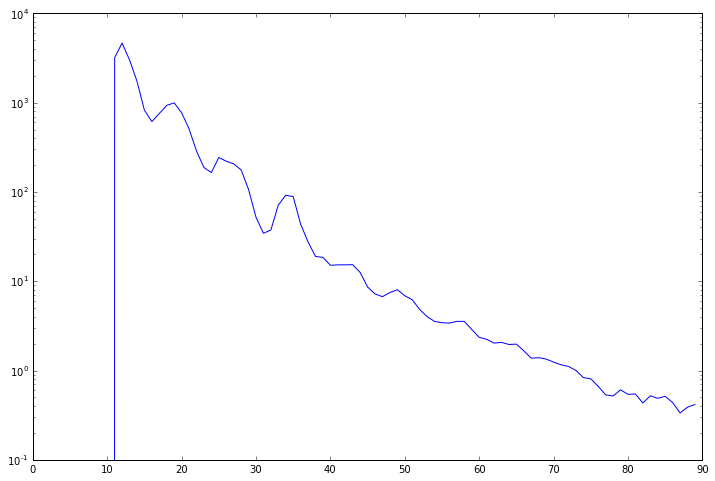

In [540]:
xi, yi, nr, nt = ahelp.getXiYiForPolarCoords(sum_image.shape,0,90)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
radial = ahelp.reprojectImageByCoords(sum_image, xi, yi, nr, nt, (138,21)).mean(axis=1)
# fill_2d_subplot(ax, polar_mask, vmin=np.amin(polar_mask),vmax=np.amax(polar_mask),logscale=False)
ax.plot(radial)
ax.set_yscale('log')

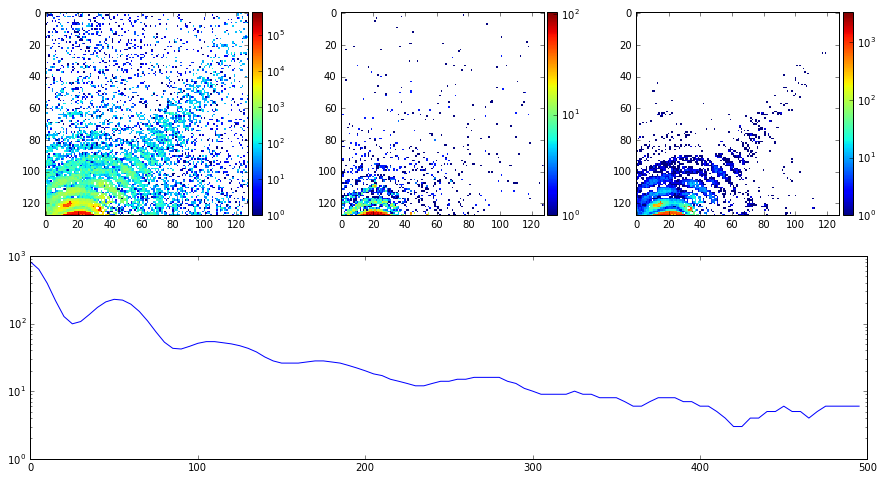

In [524]:
#Photon conversion
def convert_photons(frame):
    hist,bins = np.histogram(frame,bins=100,range = (0,500))
    noise_level = 40
    photon_ration = 60
    return np.round((frame - noise_level)/photon_ratio)

frame = adu[selected_idx[3]]
frame = adu[good_idx]
photons_frame = np.round(adu[selected_idx[0]]/40)
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(231)
fill_2d_subplot(ax,frame,vmin=1,vmax=np.amax(frame),logscale=True)

hist,bins = np.histogram(frame,bins=100,range = (0,500))
hist = gaussian_filter(hist,1.5)

ax = fig.add_subplot(212)
ax.plot(bins[:-1],hist)
ax.set_yscale('log')

new_photons = convert_photons(frame)


ax = fig.add_subplot(232)
fill_2d_subplot(ax,photons_frame,vmin=1,vmax=np.amax(photons_frame),logscale=True)
ax = fig.add_subplot(233)
fill_2d_subplot(ax,new_photons,vmin=1,vmax=np.amax(new_photons),logscale=True)


In [519]:
for i in selected_idx:
    convert_photons(adu[i])

40.0 0
40.0 65.0
40.0 60.0
35.0 65.0
40.0 65.0
40.0 0
40.0 0
40.0 155.0
45.0 230.0
40.0 60.0
40.0 160.0
40.0 220.0
45.0 125.0
40.0 0
40.0 130.0
40.0 240.0
40.0 0
40.0 345.0
45.0 60.0
40.0 0
40.0 415.0
35.0 0
40.0 0
40.0 230.0
40.0 330.0
35.0 0
40.0 0
95.0 200.0
40.0 195.0
45.0 0
40.0 0
105.0 0
45.0 0
35.0 65.0
40.0 0
345.0 0
40.0 335.0
30.0 70.0
40.0 80.0


/opt/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


IndexError: index 0 is out of bounds for axis 0 with size 0

30000 good frames in run
(16, 512, 128)


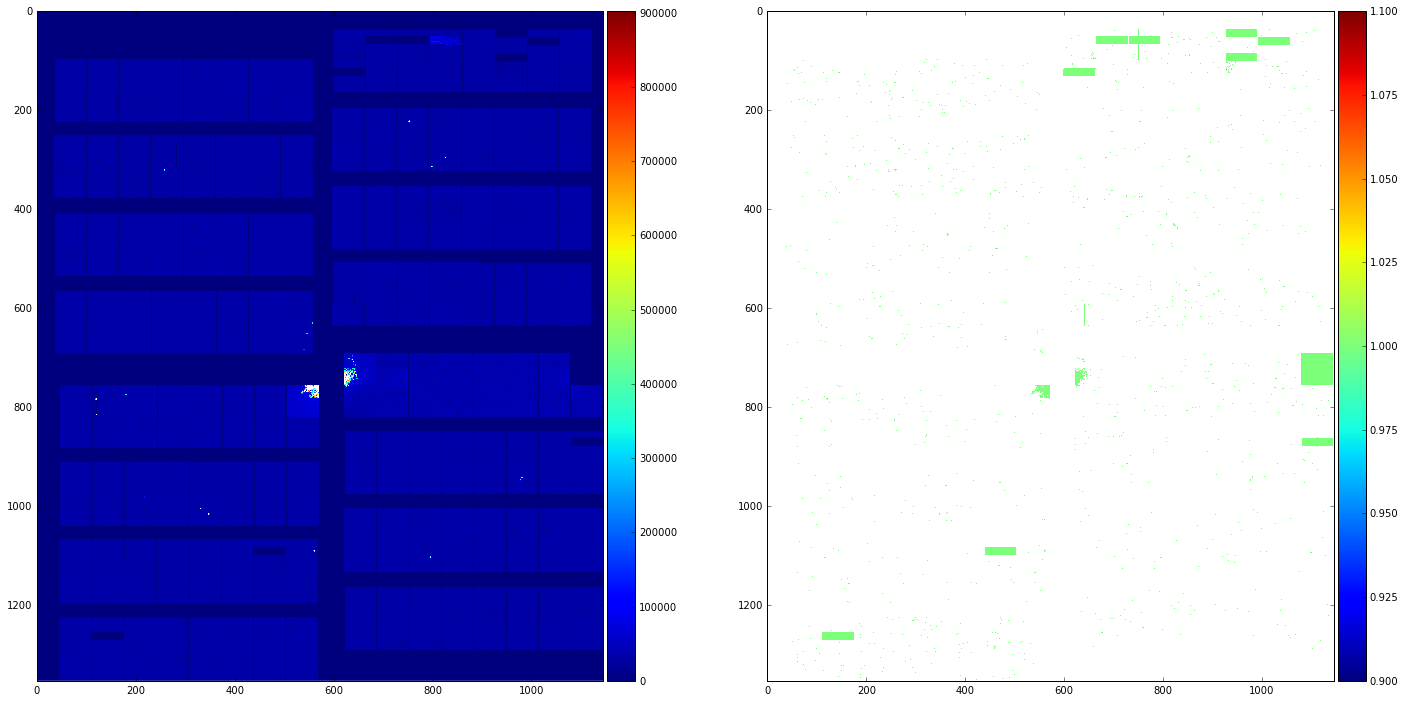

In [11]:
#Load badpix
c = combm.AGIPD_Combiner(289,calib_glob='/gpfs/exfel/exp/SPB/201701/p002013/usr/Shared/calib/r0119/Cheetah*.h5')
frame = c.get_frame(100,assemble=False,calibrate=True)
bad_pix = (frame<20000)+(frame>150000)
preview_mask = bad_pix[15,-128:]*-10000
print(frame.shape)
show_frame = frame.copy()
show_frame[bad_pix] = 10000000

geom_coord_x, geom_coord_y = geom.pixel_maps_from_geometry_file( \
                            '/gpfs/exfel/exp/SPB/201701/p002013/scratch/geom/agipd_taw9_oy2_1050addu_hmg5.geom')
frame_assembled = geom.apply_geom_ij_yx((geom_coord_x, geom_coord_y), frame).transpose()
bad_pix_assembled = geom.apply_geom_ij_yx((geom_coord_x, geom_coord_y), bad_pix).transpose()


fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(121)
fill_2d_subplot(ax, frame_assembled, vmin=0, vmax=np.amax(frame), logscale=False)
ax = fig.add_subplot(122)
fill_2d_subplot(ax, bad_pix_assembled, vmin=np.amax(bad_pix_assembled), \
                vmax=np.amax(bad_pix_assembled), logscale=False)
# sio.savemat('badpix_mask',{'mask':bad_pix})

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sum_fixed = sum_image + bad_pix[15,-128:]*10000
fill_2d_subplot(ax,sum_fixed,vmin=1,vmax=np.amax(sum_image),logscale=True)

In [ ]:
#Compare data before and after mask
xi, yi, nr, nt = ahelp.getXiYiForPolarCoords(sum_image.shape,0,180)

mask_bad_value = -10000
sum_mask = (bad_pix[15,-128:])*mask_bad_value

polar_image = ahelp.reprojectImageByCoords(sum_image, xi, yi, nr, nt, (138,21))
polar_mask = ahelp.reprojectImageByCoords(sum_mask, xi, yi, nr, nt, (138,21),cval=mask_bad_value)

# radial = np.sum(polar_image,axis=1)
polar_image_orig = polar_image.copy()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(221)
# fill_2d_subplot(ax, polar_mask, vmin=np.amin(polar_mask),vmax=np.amax(polar_mask),logscale=False)
fill_2d_subplot(ax, polar_image_orig, vmin=1,vmax=np.amax(polar_image),logscale=True)

ax = fig.add_subplot(222)
ax.plot(np.sum(polar_image_orig,axis=1))
ax.set_yscale('log')

polar_image_filled = ahelp.fill_polar_data_under_mask(polar_image, polar_mask)

ax = fig.add_subplot(223)
fill_2d_subplot(ax, polar_image_filled, vmin=1,vmax=np.amax(polar_image),logscale=True)

ax = fig.add_subplot(224)
ax.plot(np.sum(polar_image_filled,axis=1))
ax.set_yscale('log')

In [ ]:
filled_data = ahelp.fill_mask_image(sum_image, sum_mask,(138,21))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
# fill_2d_subplot(ax, polar_mask, vmin=np.amin(polar_mask),vmax=np.amax(polar_mask),logscale=False)
fill_2d_subplot(ax, filled_data, vmin=1,vmax=np.amax(filled_data),logscale=True)

In [ ]:
masked_data = images[selected_idx]

for image in masked_data:
    ahelp.fill_image_under_mask(image,sum_mask,(138,21))
    
sum_masked = masked_data.sum(axis=0)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
fill_2d_subplot(ax, sum_masked, vmin=1,vmax=np.amax(sum_masked),logscale=True)
ax = fig.add_subplot(132)
fill_2d_subplot(ax, filled_data, vmin=1,vmax=np.amax(filled_data),logscale=True)

diff_data = filled_data - sum_masked
ax = fig.add_subplot(133)
fill_2d_subplot(ax, diff_data, vmin=np.amin(diff_data),vmax=np.amax(diff_data),logscale=False)

In [ ]:
mat_data = sio.loadmat('/gpfs/exfel/u/scratch/SPB/201701/p002013/maxrose/analysis/LowIntensityMimiHitsID.mat')
print(mat_data.keys())
single_frameId = mat_data['frameID_reduced'].astype('i4').flatten()
single_runId = mat_data['runID_reduced'].astype('i4').flatten()
single_max_idx = np.array([np.nonzero( (runs==run)*(indices==frameId))[0][0] \
                           for frameId,run in zip(single_frameId,single_runId)])
print(single_runId.shape)
print(single_frameId.shape)
print(single_max_idx.shape)


/home/bobkovs/analysis_helper.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return zi.reshape((nr, nt))
/opt/anaconda/3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


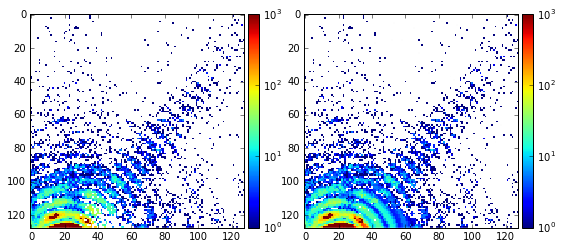

In [12]:
good_idx = np.nonzero((runs==362)*(indices==5187))[0][0]
good_image = images[good_idx]
good_image_filled = ahelp.fill_image_under_mask(good_image.copy(),preview_mask,(138,21))
fig = plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
cmap.set_under(color='white')

ax = fig.add_subplot(121)
fill_2d_subplot(ax, good_image, vmin=1, vmax=1000, logscale=True)
ax = fig.add_subplot(122)
fill_2d_subplot(ax, good_image_filled, vmin=1, vmax=1000, logscale=True)
# ax.add_artist(plt.Circle((22,139), 17, color='r', fill=False)) 
# ax.add_artist(plt.Circle((22,139), 23, color='r', fill=False)) 
# ax.add_artist(plt.Circle((22,139), 30, color='r', fill=False)) 
# ax.add_artist(plt.Circle((22,139), 37, color='r', fill=False)) 
# ax.get_xaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])

In [ ]:
kartik_hits = '/gpfs/exfel/u/scratch/SPB/201701/p002013/ayyerkar/xfel2013/offline/data/'

run_num = 362
good_event = 5187
with h5py.File(kartik_hits+'hits_r%.4d.h5'%run_num, 'r') as h5file:
    assembled = h5file['hits/assembled']
    assembled_idx = h5file['hits/indices'][:]
    good_kartik_idx = np.nonzero(assembled_idx==good_event)[0][0]
    kartik_good_image = assembled[good_kartik_idx].transpose()
    

fig = plt.figure(figsize=(12, 12))
cmap = plt.cm.jet
cmap.set_under(color='white')

ax = fig.add_subplot(131)
fill_2d_subplot(ax, kartik_good_image[600:900,500:700], vmin=1, vmax=1000, logscale=True)

c = combm.AGIPD_Combiner(run_num)
full_good_image = c.get_frame(good_event, calibrate=True, assemble=True).transpose()

ax = fig.add_subplot(132)
fill_2d_subplot(ax, full_good_image[600:900,500:700], vmin=1, vmax=1000, logscale=True)

ax = fig.add_subplot(133)
fill_2d_subplot(ax, (full_good_image-kartik_good_image)[600:900,500:700], vmin=-1000, vmax=1000, logscale=False)


(array([12, 19, 26, 33, 41, 49, 56, 63, 68, 70, 73, 78, 80, 82, 86]),)
[12 19 26 33 41 49 56 63 70 73 78 80 82 86] [16 23 30 38 45 52 59 67 72 76 79 81 83]


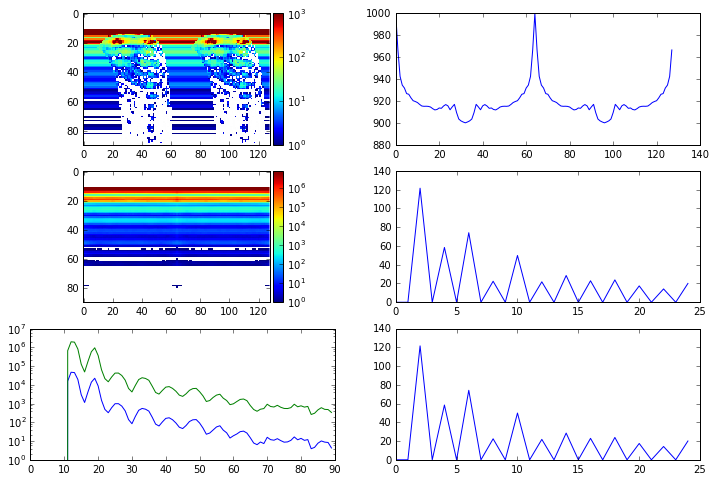

In [14]:
from scipy.fftpack import dct

xi, yi, nr, nt = ahelp.getXiYiForPolarCoords(good_image.shape)
polar_image = ahelp.reprojectImageByCoords(good_image, xi, yi, nr, nt, (138,21))
polar_mask = ahelp.reprojectImageByCoords(np.ones_like(good_image), xi, yi, nr, nt, (138,21),cval=-10000)

radial = np.sum(polar_image,axis=1)

# for local maxima
print(argrelextrema(radial, np.greater))

fig = plt.figure(figsize=(12, 8))
cmap = plt.cm.jet
cmap.set_under(color='white')

ax = fig.add_subplot(321)
fill_2d_subplot(ax,polar_image,vmin=1,vmax=1000,logscale=True)

ccf_2d = ahelp.correlate_by_angle(polar_image,polar_mask)
ccf_a = ahelp.combine_ccf_for_angles(ccf_2d)
dct_data = dct(ccf_a, norm='ortho')[:50:2]
dct_data[0] = 0

ax = fig.add_subplot(322)
ax.plot(ccf_a)

ax = fig.add_subplot(323)
fill_2d_subplot(ax,ccf_2d,vmin=1,vmax=np.amax(ccf_2d),logscale=True)

ax = fig.add_subplot(324)
ax.plot(dct_data)

ax = fig.add_subplot(325)
ax.plot(radial)
ax.plot(radial_data[good_idx])
ax.set_yscale('log')

ax = fig.add_subplot(326)
ax.plot(fvs_data[good_idx])

max_pos = argrelextrema(radial_data[good_idx], np.greater)[0]
min_pos = argrelextrema(radial_data[good_idx], np.less)[0]
print(max_pos,min_pos)
    

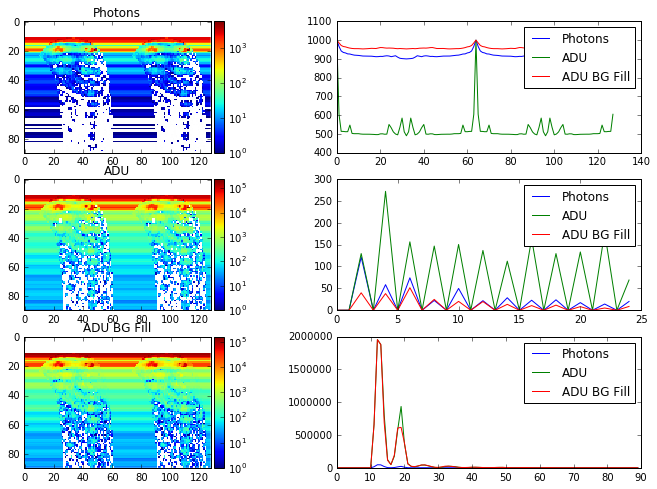

In [25]:
xi, yi, nr, nt = ahelp.getXiYiForPolarCoords(good_image.shape)
origin = (138,21)
polar_photons = ahelp.reprojectImageByCoords(photons[good_idx], xi, yi, nr, nt, origin)
polar_adu = ahelp.reprojectImageByCoords(adu[good_idx], xi, yi, nr, nt, origin)
polar_adu_bgfill = ahelp.reprojectImageByCoords(adu_bgfill[good_idx], xi, yi, nr, nt, origin)
polar_mask = ahelp.reprojectImageByCoords(np.ones_like(good_image), xi, yi, nr, nt, origin,cval=-10000)

radial_photons = np.sum(polar_photons,axis=1)
radial_adu = np.sum(np.clip(polar_adu,0,None),axis=1)
radial_adu_bgfill = np.sum(polar_adu_bgfill,axis=1)

ccf_a_photons = ahelp.combine_ccf_for_angles(ahelp.correlate_by_angle(polar_photons,polar_mask))
ccf_a_adu = ahelp.combine_ccf_for_angles(ahelp.correlate_by_angle(polar_adu,polar_mask))
ccf_a_adu_bgfill = ahelp.combine_ccf_for_angles(ahelp.correlate_by_angle(polar_adu_bgfill,polar_mask))

dct_photons = dct(ccf_a_photons, norm='ortho')[:50:2]
dct_adu = dct(ccf_a_adu, norm='ortho')[:50:2]
dct_adu_bgfill= dct(ccf_a_adu_bgfill, norm='ortho')[:50:2]
dct_photons[0] = 0
dct_adu[0] = 0
dct_adu_bgfill[0] = 0

fig = plt.figure(figsize=(12, 8))
cmap = plt.cm.jet
cmap.set_under(color='white')

ax = fig.add_subplot(321)
fill_2d_subplot(ax,polar_photons,vmin=1,vmax=np.amax(polar_photons),logscale=True)
ax.set_title('Photons')

ax = fig.add_subplot(323)
fill_2d_subplot(ax,polar_adu,vmin=1,vmax=np.amax(polar_adu),logscale=True)
ax.set_title('ADU')

ax = fig.add_subplot(325)
fill_2d_subplot(ax,polar_adu_bgfill,vmin=1,vmax=np.amax(polar_adu_bgfill),logscale=True)
ax.set_title('ADU BG Fill')

ax = fig.add_subplot(322)
ax.plot(ccf_a_photons,label='Photons')
ax.plot(ccf_a_adu,label='ADU')
ax.plot(ccf_a_adu_bgfill,label='ADU BG Fill')
ax.legend()

ax = fig.add_subplot(324)
ax.plot(dct_photons,label='Photons')
ax.plot(dct_adu,label='ADU')
ax.plot(dct_adu_bgfill,label='ADU BG Fill')
ax.legend()

ax = fig.add_subplot(326)
ax.plot(radial_photons,label='Photons')
ax.plot(radial_adu,label='ADU')
ax.plot(radial_adu_bgfill,label='ADU BG Fill')
ax.legend()

fig.savefig('Adu_photons_compare.png',dpi=300, bbox_inches='tight')

[12 19 26 33 41 49 56 63 70 73 78 80 82 86]


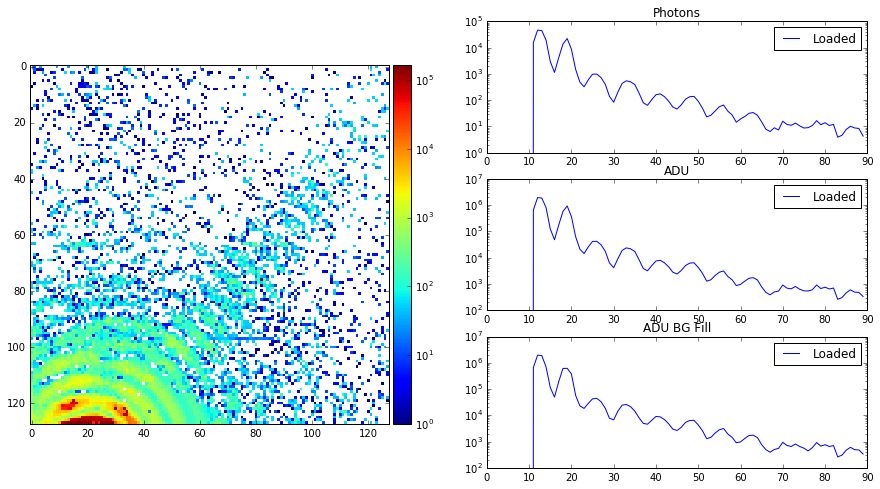

In [425]:
#Compare computed and loaded
fig = plt.figure(figsize=(15, 8))

index_filter = np.zeros_like(fringe_size)
index_filter[indices_1] = 1

used_idx = np.nonzero(index_filter*(fringe_size<5))[0][0]
used_idx = good_idx

ax = fig.add_subplot(121)
fill_2d_subplot(ax,adu_bgfill[used_idx],vmin=1,vmax=np.amax(adu_bgfill[used_idx]),logscale=True)

ax = fig.add_subplot(322)
ax.plot(radial_data_photons[used_idx],label='Loaded')
ax.set_yscale('log')
ax.set_title('Photons')
ax.legend()


ax = fig.add_subplot(324)
# ax.plot(radial_adu,label='Computed')
ax.plot(radial_data_adu[used_idx],label='Loaded')
ax.set_yscale('log')
ax.set_title('ADU')
ax.legend()


ax = fig.add_subplot(326)
# ax.plot(radial_adu_bgfill,label='Computed')
ax.plot(radial_data_adu_bgfill[used_idx],label='Loaded')
ax.set_yscale('log')
ax.set_title('ADU BG Fill')
ax.legend()

print(argrelextrema(radial_data_adu[used_idx], np.greater)[0])


In [ ]:
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111)
# ax.hist(first_max[used_filter], histtype="stepfilled", bins=20, alpha=0.8, normed=True, label='First max')
ax.scatter(fringe_size,litpix_num)

In [ ]:
corr_value = np.zeros(images.shape[0],dtype=np.float32)

first_image = np.sqrt(images[good_idx])
for i in range(images.shape[0]):
    second_image = np.sqrt(images[i])
    if i%10000 == 0:
        print(i)
    corr_value[i] = np.sum(first_image*second_image)/(np.sum(first_image)*np.sum(second_image))

In [ ]:
corr_hist,bins = np.histogram(corr_value)
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
ax.plot(bins[:-1],corr_hist, label='Corr value')
plt.legend()

In [ ]:
print('For good hit:')
print('Intensity = \t',intensity[good_idx])
print('First max = \t',first_max[good_idx])
print('Fringe size = \t',fringe_size[good_idx])
print('Size STD = \t',fringe_size_std[good_idx])
print('(2nd Max)/(1st min)= \t',min_max_ratio[good_idx])

In [ ]:
fig = plt.figure(figsize=(4, 4))
ax= fig.add_subplot(111)
ax.plot(fvs_data[good_idx])

In [ ]:
print(fringe_size.dtype)

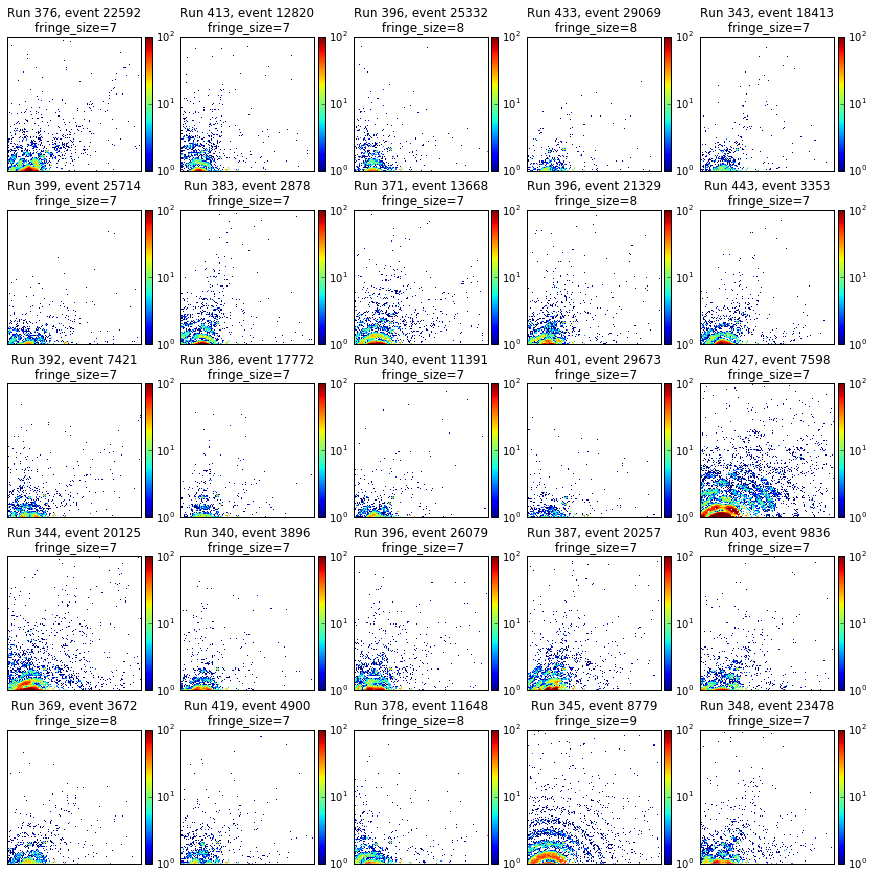

In [101]:
#Show random selected images
fig = plt.figure(figsize=(15, 15))
cmap = plt.cm.jet
cmap.set_under(color='white')

# random_in_selected_idx = [random.choice(single_hits) for i in range(25)]
random_in_selected_idx = [random.choice(selected_idx) for i in range(25)]

for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    photons = np.floor(adu[random_in_selected_idx[i]]/42)

#     fill_2d_subplot(ax, photons, vmin=np.amin(photons), vmax=np.amax(photons), logscale=False)
    fill_2d_subplot(ax, photons, vmin=1, vmax=100, logscale=True)
    ax.set_title('Run %d, event %d\n fringe_size=%d'% \
                 (runs[random_in_selected_idx[i]], indices[random_in_selected_idx[i]], \
                 fringe_size[random_in_selected_idx[i]]))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()
# fig.savefig('goodhit_shift4_362_log.png',dpi=300, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(15, 15))

for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.plot(radial_data[random_in_selected_idx[i]])
    ax.set_yscale('log')
    ax.set_title('Run %d, event %d\n FM=%d, Size=%d, STD=%d'% \
                 (runs[random_in_selected_idx[i]], indices[random_in_selected_idx[i]], \
                 first_max[random_in_selected_idx[i]],fringe_size[random_in_selected_idx[i]], \
                 fringe_size_std[random_in_selected_idx[i]]))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()

In [ ]:
idx = random_in_selected_idx[13]
fig = plt.figure(figsize=(4, 4))
ax= fig.add_subplot(111)
ax.plot(radial_data[idx])
ax.set_yscale('log')

max_pos = argrelextrema(radial_data[idx], np.greater)[0]
min_pos = argrelextrema(radial_data[idx], np.less)[0]
max_diff = [max_pos[i]-max_pos[i-1] for i in range(1,len(max_pos))]
print(max_pos[0])
print(np.mean(max_diff))
print(np.std(max_diff))
print(radial_data[i, max_pos[2]]/radial_data[i, min_pos[1]])
print(max_diff)
    

In [ ]:
mean_selected = np.sum(images[single_idx],axis=0)

print(mean_selected.shape, )

fig = plt.figure(figsize=(12, 12))
cmap = plt.cm.jet
cmap.set_under(color='white')
ax = fig.add_subplot(111)
fill_2d_subplot(ax, mean_selected, vmin=1000, vmax=1000000, logscale=True)
ax.set_title('Run %d, event %d'% (runs[single_idx[i]], indices[single_idx[i]]))
plt.show()

In [49]:
def pca(input):
    input = input - input.mean(axis=0)
    (u, s, v) = np.linalg.svd(input, full_matrices=False)
    return np.dot(input, v.T)

pca_result = pca(fvs_data_photons[selected_idx])
pca_plane = pca_result[:,0:2]

<IPython.core.display.Javascript object>


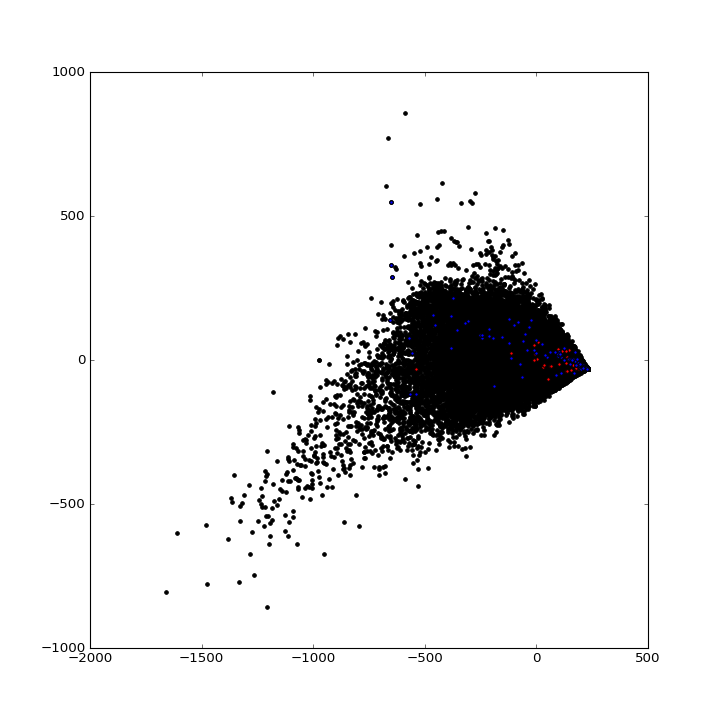

In [50]:
%matplotlib notebook

singlehit_filter = np.zeros(len(selected_filter))
singlehit_filter[single_hits] = 1
multihit_filter = np.zeros(len(selected_filter))
multihit_filter[multihits] = 1

single_inselect = np.nonzero(singlehit_filter[selected_idx])
multihit_inselect = np.nonzero(multihit_filter[selected_idx])

# color = ['k']*len(pca_plane[:,0])
# print(len(color))
# for idx in single_hits:
#     color[idx] = 'r'
    
# for idx in multihits:
#     color[idx] = 'b'

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
im = ax.scatter(pca_plane[:,0],pca_plane[:,1],s=10,c='k')
im = ax.scatter(pca_plane[single_inselect,0],pca_plane[single_inselect,1],s=10,c='r')
im = ax.scatter(pca_plane[multihit_inselect,0],pca_plane[multihit_inselect,1],s=10,c='b')

# for idx,(y,x) in enumerate(zip(pca_plane[:,0],pca_plane[:,1])):
#     ax.annotate(idx, (y,x))

# plt.savefig('pca_all.png', dpi=300, bbox_layout='tight')
plt.show()

In [51]:
%matplotlib inline

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
_,_,_,im = ax.hist2d(pca_plane[:,0],pca_plane[:,1],bins=200)
plt.colorbar(im)
plt.savefig('pca_density.png', dpi=300, bbox_layout='tight')
    

In [40]:
pca_filter = (pca_plane[:,0]>290)*(pca_plane[:,0]<340)*(pca_plane[:,1]>-95)*(pca_plane[:,1]<-60)
pca_selected_idx = np.nonzero(pca_filter)[0]
print(pca_selected_idx.shape)

(0,)


In [ ]:
%matplotlib inline

In [ ]:
MIMI_RUNS = list(range(318,321)) + \
            [340] + \
            list(range(343,350)) + \
            list(range(359,409)) + \
            list(range(411,450))
print(MIMI_RUNS)

In [ ]:
selected_run = []
selected_indices = []
selected_images = None
for run_num in MIMI_RUNS:
    try:
        with h5py.File(hits_folder+'hits_r%.4d.h5'%run_num, 'r') as h5file:
            print(run_num)
            indices = h5file['hitPreview/indices']
            if len(indices) > 0:
                selected_indices.extend(indices)
                new_images = h5file['hitPreview/images'][:]
                if selected_images == None:
                    selected_images = new_images
                else:
                    print(selected_images.shape, new_images.shape)
                    selected_images = np.vstack((selected_images,new_images))

    except OSError:
        print('Missing',run_num)
        continue
print(selected_images.shape,len(selected_run),len(selected_indices))

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/ayyerkar/xfel2013/offline/data/'
# hits_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/sbobkov/xfel2013/offline/data/'
shift2_run_numbers = range(214,267)


pp = PdfPages('/gpfs/exfel/u/scratch/SPB/201701/p002013/sbobkov/all_hits_runs_%d-%d_10s.pdf' \
              %(shift2_run_numbers[0],shift2_run_numbers[-1]))

fig = plt.figure(figsize=(11, 11))
for run_num in shift2_run_numbers:
    print(run_num)
    with h5py.File(hits_folder+'hits_r%.4d.h5'%run_num, 'r') as h5file:
        good_images = h5file['hits/assembled'][:].transpose((0, 2, 1))
        indices = h5file['hits/indices'][:]
        for i,image in enumerate(good_images):
            ax1.set_title('Run %d, event %d'%(run_num,indices[i]))
            ax1 = fig.add_subplot(111)
            im1 = ax1.imshow(image, cmap='jet', norm=colors.Normalize(vmin=40, vmax=120)) 
            plt.colorbar(im1)
#             plt.show()
            plt.savefig(pp, format='pdf',dpi=150, bbox_inches='tight')
            pp.savefig(dpi=150, bbox_inches='tight')
pp.close()

In [ ]:
c = combm.AGIPD_Combiner(52)
nframes = c.nframes

intens = np.zeros(nframes)
cell = np.zeros(nframes)
pulse = np.zeros(nframes)
images = np.zeros((nframes//30,1354, 1146))

for i in range(0,nframes,30):
    image = c.get_frame(i, calibrate=True).transpose()
    image[image<0] = 0
    image[mask<0] = 0
    images[i//30] = image
    intens[i] = np.sum(image)
    train_id, cell_id, pulse_id = c.get_frame_id(i)
    cell[i] = cell_id
    pulse[i] = pulse_id
    
    if i%100 == 0:
        print(i)

In [ ]:
scratch_folder = '/gpfs/exfel/u/scratch/SPB/201701/p002013/sbobkov/'

# h5data.close()

# h5data = h5py.File(scratch_folder+'r98_extracted_images.h5', 'r')

# images_dset = h5data['images']

In [ ]:
intensity = np.zeros(images_dset.shape[0:2])
for i in range(images_dset.shape[0]):
    for j in range(30):
        image = images_dset[i,j,:,:]
        image[image<0] = 0
        intensity[i,j] = np.sum(image)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
im_1 = ax1.plot(intensity[:,0])

In [ ]:
train,cell = np.where(intensity<np.mean(intensity)/8)
train_1 = train[cell==0]

In [ ]:
images_dset.shape

In [ ]:
std_image = np.std(images_dset[train_1,0],axis=0)

In [ ]:
image_num=20130
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
im_1 = ax1.imshow(images_dset[train[0],cell[0],:,:], cmap='jet', norm=colors.Normalize(vmin=0, vmax=120)) 
plt.colorbar(im_1)

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
im_1 = ax1.imshow(mean_noise[0], cmap='jet') 
plt.colorbar(im_1)


In [ ]:
h5bg3 = h5py.File(scratch_folder+'r296_background.h5', 'r')
mean_noise = h5bg3['background']
bad_pixels = h5bg3['bad_pixels']
# h5bg.close()

In [ ]:
h5out = h5py.File(scratch_folder+'bad_background.h5', 'w')
new_bad_pixels = bad_pixels[:]
new_bad_pixels[mean_noise[:]>500] = 1
h5out['bad_pixels'] = new_bad_pixels
h5out['cell_ids'] = h5bg3['cell_ids'][:]
h5out.close()

In [ ]:
h5file = h5py.File(scratch_folder+'r296_extracted_images.h5', 'r')
images_dset = h5file['images']
good_cells = h5file['cell_ids'][:]

cell_num = len(good_cells)

# for i in range(1):
#     print 'cell %d of %d' % (i, cell_num)
#     intensity = np.mean(images_dset[:,i,:,:], axis=(1,2))
#     selected_images = intensity < np.mean(intensity)//8
#     mean_noise = np.mean(images_dset[:,i,:,:], axis=0)
images = images_dset[7:25,0,:,:]
images[images<0] = 0
mean_noise = np.mean(images, axis=0)


In [ ]:
# mn = mean_noise[0]

# mean_mean = np.mean(mn[mn!=0])
# std_mean = np.std(mn[mn!=0])
# lim_min = mean_mean-std_mean*3
# lim_max = mean_mean+std_mean*3
# print(lim_min, lim_max)

# bad_pixels = (mn>lim_max) + (mn<lim_min) 
# bad_pixels[mean_noise[:]>500] = 1

# mn[mn<0] = 0
print(mean_noise.shape)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)

cmap = plt.cm.jet
cmap.set_under(color='black')

im_1 = ax1.imshow(mean_noise[600:900,400:800], cmap=cmap,norm=colors.Normalize(vmin=50, vmax=700))
# im_1 = ax1.imshow(mean_noise[0], cmap='jet') 
plt.colorbar(im_1)


In [ ]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
im_1 = ax1.imshow(bad_pixels, cmap='jet',norm=colors.Normalize(vmin=0, vmax=120)) 
plt.colorbar(im_1)

In [ ]:
#Shift 3
text = """
Run 228, event 27936;
Run 234, event 12118;
Run 234, event 12919;
Run 234, event 14520;
Run 238, event 1420;
Run 241, event 3669;
Run 244, event 5721;
Run 244, event 7240;
Run 244, event 9753;
Run 247, event 12613;
Run 247, event 21346;
Run 248, event 11893;
Run 248, event 25733;
Run 255, event 4736;
Run 257, event 5809;
Run 257, event 15952;
Run 259, event 9560;
Run 262, event 8942;
Run 263, event 7582;
Run 264, event 19785;
Run 267, event 16379"""

good_runs = []
good_events = []

for i,line in enumerate(text.split(';')):
    good_runs.append(int(line[4:8]))
    good_events.append(int(line[15:]))

print(good_runs, good_events)

In [ ]:
#Shift 4
text = """
Run 318, event 939;
Run 318, event 1948;
Run 318, event 2103;
Run 318, event 2359;
Run 318, event 2411;
Run 318, event 3486;
Run 318, event 4843;
Run 318, event 5094;
Run 318, event 5754;
Run 318, event 10215;
Run 318, event 10589;
Run 318, event 14338;
Run 318, event 15511;
Run 318, event 18432;
Run 318, event 28529"""

good_runs = []
good_events = []

for i,line in enumerate(text.split(';')):
    good_runs.append(int(line[4:8]))
    good_events.append(int(line[15:]))

print(good_runs, good_events)
print(len(good_runs))

In [ ]:
run_318_single = [np.where((runs==r)*(indices==i))[0][0] for r,i in zip(good_runs,good_events)]
print(run_318_single)


In [ ]:
#Shift 4
text = """
Run 340, event 6466;
Run 340, event 10233;
Run 340, event 29786"""

good_runs = []
good_events = []

for i,line in enumerate(text.split(';')):
    good_runs.append(int(line[4:8]))
    good_events.append(int(line[15:]))

print(good_runs, good_events)
print(len(good_runs))

In [ ]:
#Shift 4
text = """
Run 345, event 7548;
Run 345, event 8519;
Run 345, event 8614;
Run 345, event 20064;
Run 346, event 14896;
Run 346, event 17759;
Run 346, event 22505;
Run 346, event 22629;
Run 346, event 28173"""

good_runs = []
good_events = []

for i,line in enumerate(text.split(';')):
    good_runs.append(int(line[4:8]))
    good_events.append(int(line[15:]))

print(good_runs, good_events)
print(len(good_runs))

In [ ]:
#Shift 4
text = """
Run 362, event 5187"""

good_runs = []
good_events = []

for i,line in enumerate(text.split(';')):
    good_runs.append(int(line[4:8]))
    good_events.append(int(line[15:]))

print(good_runs, good_events)
print(len(good_runs))

In [ ]:
fig = plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
cmap.set_under(color='white')

for i in range(len(good_runs)):
    ax = fig.add_subplot(1,1,i+1)
    if i==0 or good_runs[i]>good_runs[i-1]:
        c = combm.AGIPD_Combiner(good_runs[i])
    image = c.get_frame(good_events[i], calibrate=True).transpose()
    fill_2d_subplot(ax, image[500:900,400:800], vmin=40, vmax=1000, logscale=True)
    ax.set_title('Run %d, event %d'% (good_runs[i], good_events[i]))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
plt.show()
fig.savefig('goodhit_shift4_362_log.png',dpi=300, bbox_inches='tight')
    

In [ ]:
good_images = np.zeros((len(good_runs),image.shape[0],image.shape[1]))
for i in range(len(good_runs)):
    if i==0 or good_runs[i]>good_runs[i-1]:
        c = combm.AGIPD_Combiner(good_runs[i])
    good_images[i,:,:] = c.get_frame(good_events[i], calibrate=True).transpose()
    
sum_image = np.sum(good_images,axis=0)

In [ ]:
fig = plt.figure(figsize=(11, 9))
cmap = plt.cm.jet
cmap.set_under(color='white')

ax = fig.add_subplot(111)
fill_2d_subplot(ax, sum_image[500:900,400:800], vmin=200, vmax=10000, logscale=True)

plt.show()
fig.savefig('sumhits_shift4_318_log.png',dpi=300, bbox_inches='tight')

In [ ]:
averaged_image = np.mean(images[:150,:,:], axis=0)
min_image = np.amin(images[:150,:,:], axis=0)
std_image = np.std(images[:150,:,:], axis=0)

In [ ]:
f = h5py.File(scratch_folder+'r52_background.h5', 'w')
f['background'] = averaged_image
f['bad_pixels'] = std_image>10
f.close()

In [ ]:
background_image = averaged_image
bad_pixels = std_image>10

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(311)
fill_2d_subplot(ax1, averaged_image, logscale=False, vmin=np.amin(averaged_image))

ax2 = fig.add_subplot(312)
fill_2d_subplot(ax2, min_image, logscale=False, vmin=np.amin(min_image))

ax3 = fig.add_subplot(313)
fill_2d_subplot(ax3, std_image, logscale=False, vmin=np.amin(std_image))

In [ ]:
std_filter = std_image > 10

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(311)
fill_2d_subplot(ax1, std_filter, logscale=False, vmin=np.amin(std_filter))

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(211)
p1 = ax1.plot(intens)
ax2 = fig.add_subplot(212)
p2 = ax2.plot(cell)
p3 = ax2.plot(pulse)

In [ ]:
corrected_images = images - background_image
corrected_images.shape
corrected_images[:,bad_pixels] = 0

In [ ]:
intensity_corrected = np.mean(corrected_images, axis=0)

fig = plt.figure(figsize=(15, 15))
ax2 = fig.add_subplot(111)
im_1 = ax2.plot(intensity_corrected)  

In [ ]:
image_1 = c.get_frame(60, calibrate=True).transpose()
image_1 -= background_image
image_1[bad_pixels] = 0
image_1[image_1<0] = 0

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(211)
im_1 = ax1.imshow(image_1, cmap='jet')  
plt.colorbar(im_1)
ax2 = fig.add_subplot(212)
hist,bins = np.histogram(image_1.flatten(),bins=100)
im_1 = ax2.plot(bins[1:-1],hist[1:])

In [ ]:
f = h5py.File(scratch_folder+'r54_extracted_images_cell02.h5', 'r')
data = f['images']
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
im_1 = ax1.imshow(data[230,:,:], cmap='jet')  